# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime
#import cv2
def imread(path):
    from PIL import Image
    return np.array(Image.open(path))

def imresize(img, size):
    from PIL import Image
    return np.array(Image.fromarray(img).resize(size))

### Note :"from scipy.misc import imread, imresize" is been depreciated and thus using alternative defination.

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

### Note : "set_random_seed" has been depreciated and thus using "random.set_seed".

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 80 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[i*2 for i in range(15)]  #create a list of image numbers you want to use for a particular video
    x = len(img_idx) #Number of images in a sequence.
    y = 64 #Height of image
    z = 64 #Width of image
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
                    #Normalising using mean value of image.
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image 
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
  
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs =35 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 35


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1 (Conv3D):

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
#Updation in Generator as well
x = 15  #Updation in Generator as well
y = 64
z = 64 

#Input layer
model = Sequential()
model.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#Hidden Layer
model.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same',activation='relu'))
model.add(BatchNormalization())

# model.add(Dropout(0.25))

model.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#Dense and output layer.
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
optimiser =  optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 64, 64, 64)    5248      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 64, 64, 64)    256       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 32, 32, 64)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 32, 32, 128)    221312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 32, 32, 128)    512       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 16, 16, 128)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 16, 16, 256)    8

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Updating checkpoint only for best model because of space constraints.
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 80


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/35
9/9 [==============================] - 50s 5s/step - loss: 14.0131 - categorical_accuracy: 0.2533 - val_loss: 187.3964 - val_categorical_accuracy: 0.2300
Epoch 2/35
9/9 [==============================] - 34s 4s/step - loss: 1.6063 - categorical_accuracy: 0.3915 - val_loss: 66.9968 - val_categorical_accuracy: 0.2200
Epoch 3/35
9/9 [==============================] - 36s 4s/step - loss: 1.2371 - categorical_accuracy: 0.5138 - val_loss: 35.0724 - val_categorical_accuracy: 0.2300
Epoch 4/35
9/9 [==============================] - 33s 4s/step - loss: 1.0150 - categorical_accuracy: 0.6026 - val_loss: 25.5914 - val_categorical_accuracy: 0.2500
Epoch 5/35
9/9 [==============================] - 36s 4s/step - loss: 0.8847 - categorical_accuracy: 0.6254 - val_loss: 17.3618 - val_categorical_accuracy: 0.2300
Epoch 6/35
9/9 [==============================] - 33s 4s/step - loss: 0.8925 - categorical_accuracy: 0.6610 - val_loss: 12.1277 - val_categorical_accuracy: 0.1800
Epoch 7/35
9/9 [====

#### Note :"model.fit_generator" is depreciated and  "model.fit" supports the generator functionality.

### Visualizing training results

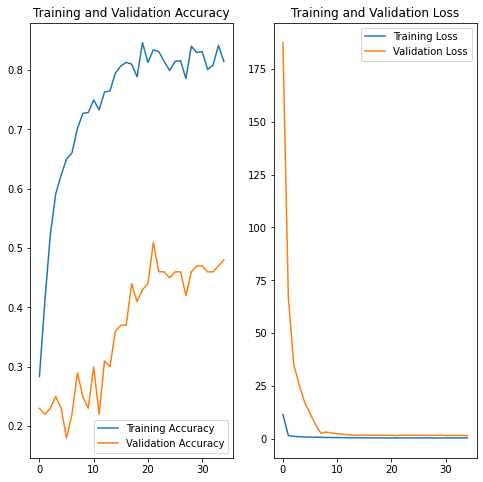

In [12]:
import matplotlib.pyplot as plt


acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model architecture can be finetuned to improve the accuracy.
1. Changing image dimension and image normalisation strategy.
2. Changing activation function to Elu.
3. Making Batch normalisation before Elu

### Model 2 (Conv3D):

In [13]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [14]:
#Batch size
batch_size = 70 

In [15]:
#Defining generator.
def generator_2(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[i*2 for i in range(15)]  #create a list of image numbers you want to use for a particular video
    x = len(img_idx) #Number of images in a sequence.
    y = 80 #Height of image
    z = 80 #Width of image
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
                    #Normalising using mean value of image.
                    #Mean Red -122 ,Mean Green -113,Mean Blue -108
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 122 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 113 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 108 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
  
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 122  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 113  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 108  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [16]:
curr_dt_time = datetime.datetime.now()
# choose the number of epochs
num_epochs =30 
print ('# epochs =', num_epochs)

# epochs = 30


In [17]:
#Model update
#Updation in Generator as well
x = 15  #Number of images
y = 80  #Height of image
z = 80  #Width of image

#Input layer
model2 = Sequential()
model2.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#Hidden layer
model2.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#model.add(Dropout(0.2))
#Hidden layer
model2.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('elu'))

#model.add(Dropout(0.25))
#Hidden layer
model2.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('elu'))
model2.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#Dense and output layer.
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='elu'))
model2.add(Dropout(0.5))
model2.add(Dense(5, activation='softmax'))

In [18]:
optimiser2 =  optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True) #write your optimizer
model2.compile(optimizer=optimiser2, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 15, 80, 80, 64)    5248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 15, 80, 80, 64)    256       
_________________________________________________________________
activation (Activation)      (None, 15, 80, 80, 64)    0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 40, 40, 64)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 7, 40, 40, 128)    221312    
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 40, 40, 128)    512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 40, 40, 128)   

In [19]:
#generator 
train_generator = generator_2(train_path, train_doc, batch_size)
val_generator = generator_2(val_path, val_doc, batch_size)

In [20]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Updating checkpoint only for best model because of space constraints.
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#callbacks_list = [LR]

In [21]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [22]:
#Fitting the model.
history = model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 70


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
10/10 [==============================] - 54s 5s/step - loss: 16.2350 - categorical_accuracy: 0.2161 - val_loss: 159.8827 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model_init_2021-09-1315_22_51.930806/model-00001-12.49715-0.24284-159.88266-0.20000.h5
Epoch 2/30
10/10 [==============================] - 37s 4s/step - loss: 2.1387 - categorical_accuracy: 0.3958 - val_loss: 55.6696 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2021-09-1315_22_51.930806/model-00002-1.92418-0.41478-55.66961-0.26000.h5
Epoch 3/30
10/10 [==============================] - 39s 4s/step - loss: 1.5864 - categorical_accuracy: 0.4978 - val_loss: 21.4147 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to model_init_2021-09-1315_22_51.930806/model-00003-1.46953-0.49623-21.41467-0.30000.h5
Epoch 4/30
10/10 [==============================] - 37s 4s/step - loss: 1.5551 - categorical_accuracy: 0.4620 - val_loss: 17.6312 - val_categorical_accuracy

### Visualizing training results

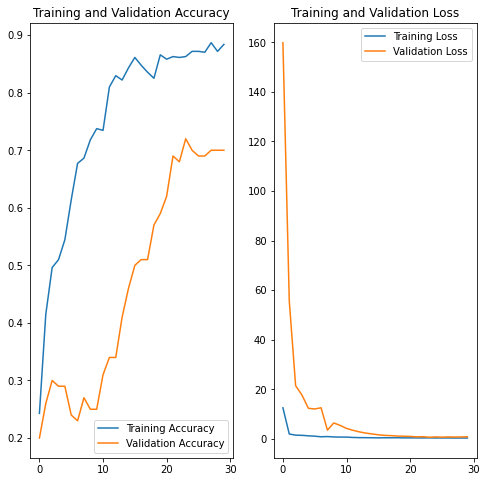

In [23]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Model architecture can be improved  by increasing the deapth of the network.

### Model 3 (Conv3D):

In [24]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [25]:
#Batch size
batch_size = 70 

In [26]:
#Defining the Generator
def generator_3(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,28]  #create a list of image numbers you want to use for a particular video
    x = len(img_idx) #Number of images in a sequence.
    y = 80 #Height of image
    z = 80 #Width of image
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
                    #Normalising using mean value of image.
                    #Mean Red -122 ,Mean Green -113,Mean Blue -108
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 122 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 113 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 108 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
  
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 122  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 113  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 108  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [27]:
curr_dt_time = datetime.datetime.now()
# choose the number of epochs
num_epochs =35 
print ('# epochs =', num_epochs)

# epochs = 35


In [28]:
#Defining the Model

#Updation in Generator as well
x = 16  #Number of images
y = 80  #Height of image
z = 80  #Width of image

#Input layer
model3 = Sequential()
model3.add(Conv3D(64, (3,3,3), strides=(1,1,1), padding='same', input_shape=(x,y,z,3)))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#Hidden layer
model3.add(Conv3D(128, (3,3,3), strides=(1,1,1), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#model.add(Dropout(0.2))
#Hidden layer
model3.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#Hidden layer
model3.add(Conv3D(256, (3,3,3), strides=(1,1,1), padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('elu'))
model3.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

#Dense and output layer.
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(512, activation='elu'))
model3.add(Dropout(0.5))
model3.add(Dense(5, activation='softmax'))

In [29]:
optimiser3 =  optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True) #write your optimizer
model3.compile(optimizer=optimiser3, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 80, 80, 64)    5248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 80, 80, 64)    256       
_________________________________________________________________
activation_4 (Activation)    (None, 16, 80, 80, 64)    0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 8, 40, 40, 64)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 40, 40, 128)    221312    
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 40, 40, 128)    512       
_________________________________________________________________
activation_5 (Activation)    (None, 8, 40, 40, 128)   

In [30]:
#generator 
train_generator = generator_3(train_path, train_doc, batch_size)
val_generator = generator_3(val_path, val_doc, batch_size)

In [31]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'


checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#callbacks_list = [LR]

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
#Fitting the model.
history = model3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 70
Epoch 1/35
10/10 [==============================] - 58s 5s/step - loss: 12.6844 - categorical_accuracy: 0.2785 - val_loss: 145.7147 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-09-1315_42_19.133766/model-00001-10.32440-0.31976-145.71469-0.23000.h5
Epoch 2/35
10/10 [==============================] - 39s 4s/step - loss: 1.7484 - categorical_accuracy: 0.4018 - val_loss: 55.3310 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2021-09-1315_42_19.133766/model-00002-1.73011-0.38311-55.33095-0.23000.h5
Epoch 3/35
10/10 [==============================] - 41s 4s/step - loss: 1.6166 - categorical_accuracy: 0.3943 - val_loss: 15.2851 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model_init_2021-09-1315_42_19.133766/model-00003-1.57050-0.39668-15.28509-0.23000.h5
Epoch 4/35
10/10 [==============================] - 39s 4s/step - loss: 1.7858 - categorical_accuracy: 0

### Visualizing training results

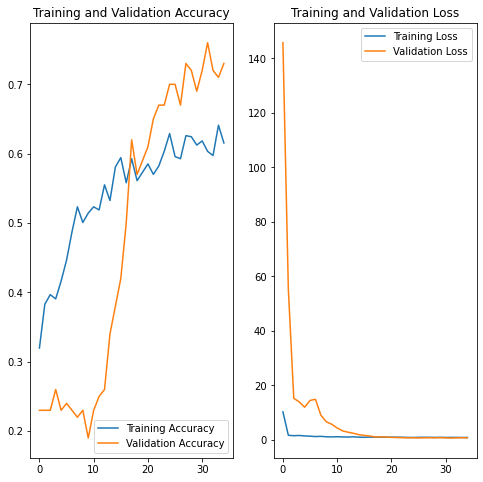

In [34]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Changing the model architecture to 2dCNN+RNN based architecture.

In [35]:
#!pip install numpy==1.19.5

### Model 4 (ConvGRU):

In [36]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [37]:
#Batch size
batch_size = 40 

In [38]:
def generator_4(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[i*2 for i in range(15)]  #create a list of image numbers you want to use for a particular video
    x = len(img_idx) #Number of images in a sequence.
    y = 120 #Height of image
    z = 120 #Width of image
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
                    #Normalising using mean value of image.
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image 
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
  
                    batch_data[folder,idx,:,:,0] = image[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [39]:
curr_dt_time = datetime.datetime.now()
# choose the number of epochs
num_epochs =30 
print ('# epochs =', num_epochs)

# epochs = 30


In [40]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg19 import VGG19

#Defining model 
img_seq = 15
y=120
z=120

#BaseModel
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(y,z,3))
x = base_model.output
x = Flatten()(x)

#x.add(Dropout(0.5))

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False

#Sequential model.
model4 = Sequential()
model4.add(TimeDistributed(conv_model, input_shape=(img_seq,y,z,3)))

model4.add(GRU(64, return_sequences=True))
model4.add(GRU(16))

model4.add(Dropout(0.5))

model4.add(Dense(64, activation='relu'))
model4.add(Dense(5, activation='softmax'))

In [41]:
optimiser4 =  optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True) #write your optimizer
model4.compile(optimizer=optimiser4, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 64)            20319360  
_________________________________________________________________
gru (GRU)                    (None, 15, 64)            24960     
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                3936      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 325       
Total params: 20,349,669
Trainable params: 325,285
Non-trainable params: 20,024,384
____________________________________

In [42]:
#generator 
train_generator = generator_4(train_path, train_doc, batch_size)
val_generator = generator_4(val_path, val_doc, batch_size)

In [43]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Updating checkpoint only for best model because of space constraints.
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
#callbacks_list = [checkpoint, LR]
callbacks_list = [LR]

In [44]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [45]:
#Fitting the model.
history = model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 40
Epoch 1/30
17/17 [==============================] - 129s 7s/step - loss: 1.6201 - categorical_accuracy: 0.2376 - val_loss: 1.5830 - val_categorical_accuracy: 0.2900
Epoch 2/30
17/17 [==============================] - 99s 6s/step - loss: 1.6030 - categorical_accuracy: 0.2418 - val_loss: 1.5502 - val_categorical_accuracy: 0.3400
Epoch 3/30
17/17 [==============================] - 63s 4s/step - loss: 1.5525 - categorical_accuracy: 0.3112 - val_loss: 1.5385 - val_categorical_accuracy: 0.3900
Epoch 4/30
17/17 [==============================] - 41s 3s/step - loss: 1.5017 - categorical_accuracy: 0.3774 - val_loss: 1.4430 - val_categorical_accuracy: 0.4700
Epoch 5/30
17/17 [==============================] - 40s 2s/step - loss: 1.4295 - categorical_accuracy: 0.4082 - val_loss: 1.4392 - val_categorical_accuracy: 0.4100
Epoch 6/30
17/17 [==============================] - 40s 2s/step - loss: 1.4651 - categorical_accuracy: 0.3426 - val_loss: 1.364

### Visualizing training results

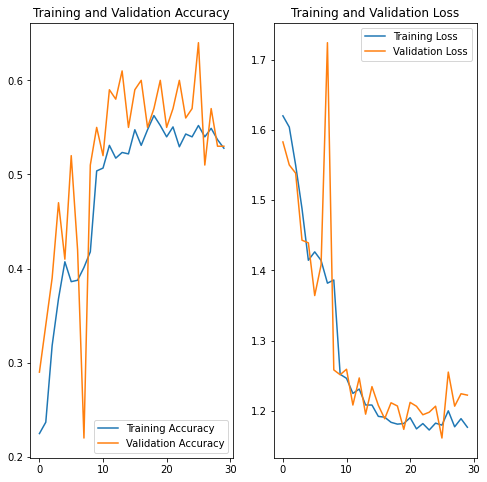

In [46]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overall accuracy can be improved by normalising image by Subtracting pixel value per channel by mean value per channel.

### Model 5 (ConvGRU):

In [47]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

In [48]:
#Batch size
batch_size = 40

In [49]:
#Defining the generator
def generator_5(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =[0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,28]  #create a list of image numbers you want to use for a particular video
    x = len(img_idx) #Number of images in a sequence.
    y = 120 #Height of image
    z = 120 #Width of image
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
                    #Normalising using mean value of image.
                    #Mean Red -122 ,Mean Green -113,Mean Blue -108
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 122 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 113 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 108 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,x,y,z,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    if image.shape[1] == 160:
                        #Adjusting the width to 120 
                        image = imresize(image[:,20:140,:], (y,z)).astype(np.float32)
                    else:
                        image = imresize(image, (y,z)).astype(np.float32)
  
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 122  #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 113  #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 108  #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [50]:
curr_dt_time = datetime.datetime.now()
# choose the number of epochs
num_epochs =35 
print ('# epochs =', num_epochs)

# epochs = 35


In [51]:
#Model Building Code.
img_seq = 16
y=120
z=120

base_model = VGG19(include_top=False, weights='imagenet', input_shape=(y,z,3))
x = base_model.output
x = Flatten()(x)

#x.add(Dropout(0.5))

features = Dense(64, activation='relu')(x)
conv_model = Model(inputs=base_model.input, outputs=features)
    
for layer in base_model.layers:
    layer.trainable = False
        
model5 = Sequential()
model5.add(TimeDistributed(conv_model, input_shape=(img_seq,y,z,3)))

model5.add(GRU(32, return_sequences=True))
model5.add(GRU(16))

model5.add(Dropout(0.5))

model5.add(Dense(64, activation='relu'))
model5.add(Dense(5, activation='softmax'))

In [52]:
optimiser5 =  optimizers.SGD(learning_rate=0.01, decay=1e-5, momentum=0.7, nesterov=True) #write your optimizer
model5.compile(optimizer=optimiser5, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 16, 64)            20319360  
_________________________________________________________________
gru_2 (GRU)                  (None, 16, 32)            9408      
_________________________________________________________________
gru_3 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                1088      
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 325       
Total params: 20,332,581
Trainable params: 308,197
Non-trainable params: 20,024,384
____________________________________

In [53]:
#generator 
train_generator = generator_5(train_path, train_doc, batch_size)
val_generator = generator_5(val_path, val_doc, batch_size)

In [54]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

#Updating checkpoint only for best model because of space constraints.
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]
#callbacks_list = [LR]

In [55]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [56]:
#Fitting the model.
history = model5.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 40
Epoch 1/35
17/17 [==============================] - 170s 9s/step - loss: 1.6564 - categorical_accuracy: 0.1972 - val_loss: 1.5507 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2021-09-1316_28_58.479490/model-00001-1.62785-0.22323-1.55073-0.35000.h5
Epoch 2/35
17/17 [==============================] - 143s 9s/step - loss: 1.5310 - categorical_accuracy: 0.3242 - val_loss: 1.4833 - val_categorical_accuracy: 0.3800

Epoch 00002: saving model to model_init_2021-09-1316_28_58.479490/model-00002-1.51656-0.32881-1.48333-0.38000.h5
Epoch 3/35
17/17 [==============================] - 139s 9s/step - loss: 1.4048 - categorical_accuracy: 0.4143 - val_loss: 1.3746 - val_categorical_accuracy: 0.4700

Epoch 00003: saving model to model_init_2021-09-1316_28_58.479490/model-00003-1.39947-0.39970-1.37464-0.47000.h5
Epoch 4/35
17/17 [==============================] - 135s 8s/step - loss: 1.3263 - categorical_accuracy: 0.4576 

### Visualizing training results

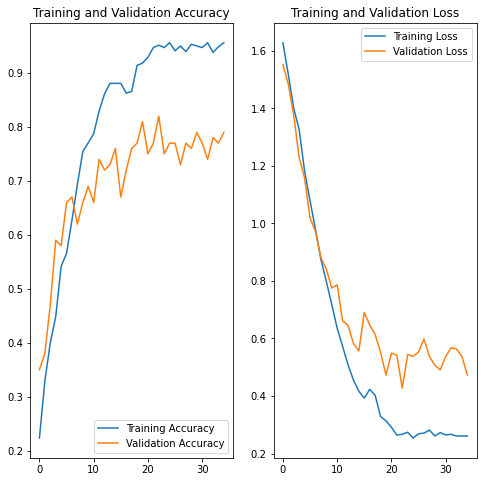

In [57]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Conclusion: 
Model 2 (Conv3D, experiment 8) and Model 5 (ConvGRU, experiment 11) have produced very good accuracy score of around 72% and 82% respectively. But ConvGRU based models have lot more parameters when compared to conv3D based models. And, since the overall objective is to obtain a better performing model with lesser number of parameters conv3D model can be used for final model evaluation.

Use Model 2(Conv3D) architecture with corresponding .h5 file for final test evaluation.

Further accuracy of the model can be improved using data augmentation technique.